In [1]:
import yaml
import sys
import os
import numpy as np
import torch 
os.chdir('/home/jonfrey/PLR3')
sys.path.insert(0, os.getcwd())
sys.path.append(os.path.join(os.getcwd() + '/src'))
sys.path.append(os.path.join(os.getcwd() + '/lib'))

import loaders_v2
from loaders_v2 import GenericDataset
from rotations import * 
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from visu import plot_pcd, Visualizer
import copy
from scipy.spatial.transform import Rotation as R
from helper import re_quat
from PIL import Image, ImageDraw
from deep_im import LossAddS
import copy
#from deep_im import flow_to_trafo
from visu import Visualizer
import matplotlib.pyplot as plt
import k3d
#exp_cfg_path = '/home/jonfrey/PLR3/yaml/exp/exp_ws_deepim_debug_natrix.yml'

env_cfg_path = '/home/jonfrey/PLR3/yaml/env/env_natrix_jonas.yml'
exp_cfg_path = '/home/jonfrey/PLR3/yaml/exp/exp_evaluate_pose_estimation.yml'
h = 480
w = 640
import k3d

def load_from_file(p):
    if os.path.isfile(p):
        with open(p, 'r') as f:
            data = yaml.safe_load(f)
    else:
        raise ValueError
    return data

exp = load_from_file(exp_cfg_path)
env = load_from_file(env_cfg_path)

dataset_train = GenericDataset(
    cfg_d=exp['d_train'],
    cfg_env=env)

batch = dataset_train[13450][0] #bann 10450
points, choose, img, target, model_points, idx = batch[0:6]
depth_img, label_img, img_orig, cam = batch[6:10]
gt_rot_wxyz, gt_trans, unique_desig = batch[10:13]

real_img, render_img, real_d, render_d, gt_label_cropped = batch[13:18]
pred_rot_wxyz, pred_trans, pred_points, h_render,h_real, render_img_original = batch[18:24]
u_map, v_map, flow_mask,  bb , depth_render_original= batch[24:]



/home/jonfrey/PLR3/src/helper/bounding_box.py:203: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  masked_idx = (d != 0).nonzero()
/home/jonfrey/miniconda3/envs/track_latest/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


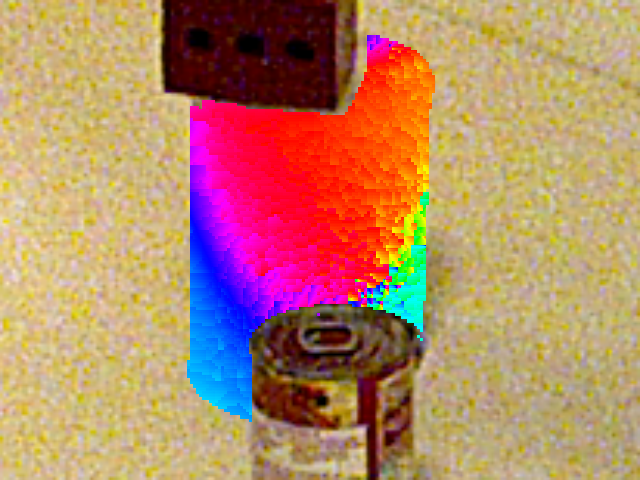

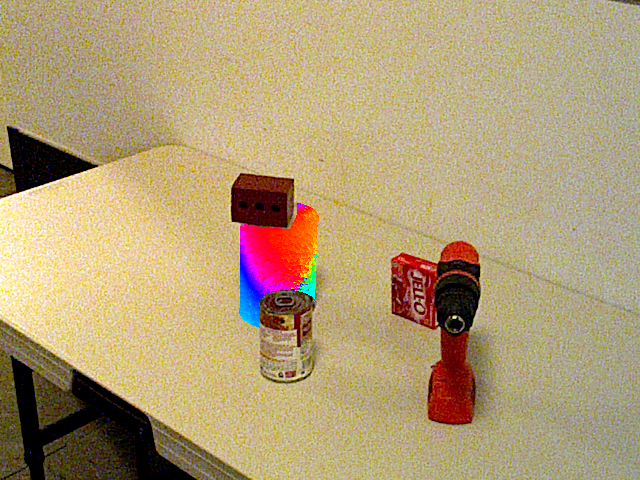

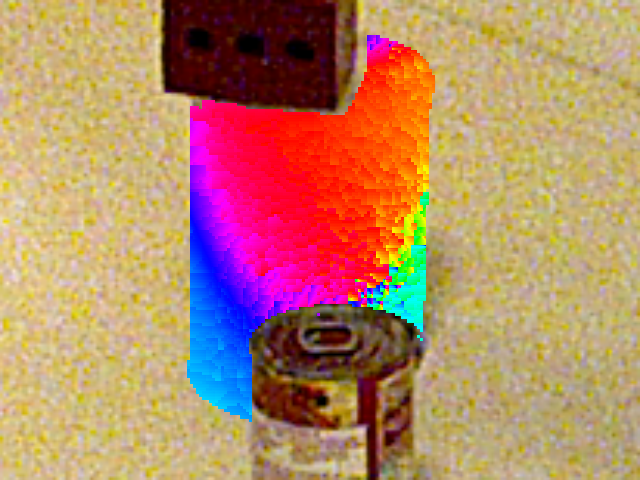

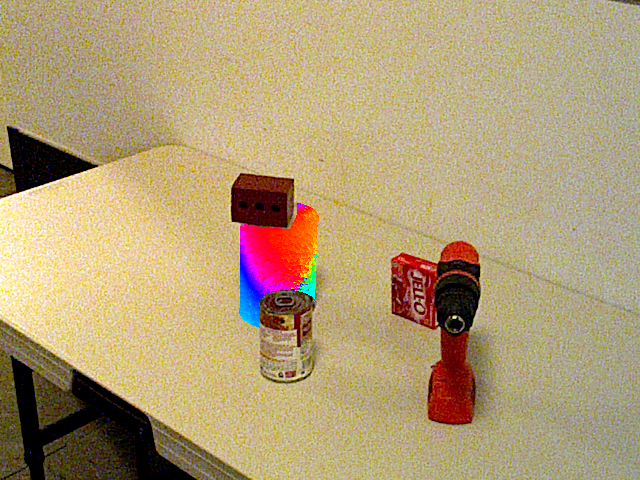

Done


In [3]:
from visu import *
visualizer = Visualizer('/home/jonfrey/Debug', None)


def flow_to_gradient(img, flow, mask,tl=[0,0], br=[479,639]):
    """
    img torch.tensor(h,w,3)
    flow torch.tensor(h,w,2)
    mask torch.tensor(h,w) BOOL
    call with either: 
    flow_to_gradient( np.uint8( real_img.numpy() ), flow.clone(), (gt_label_cropped == idx+1) )
    flow_to_gradient( np.uint8( img_orig.numpy() ), flow.clone(), (label_img == idx+1),  real_tl, real_br)
    """
    s = 1000
    Nc = int( np.math.pi*2 * s)
    cmap = plt.cm.get_cmap('hsv', Nc)
    cmaplist = [cmap(i) for i in range(cmap.N)]

    flow = flow
    amp = torch.norm(flow, p=2, dim=2)
    amp = amp / (torch.max(amp)+1.0e-6)  # normalize the amplitude
    dir_bin = torch.atan2(flow[:, :, 0], flow[:, :, 1])
    dir_bin *= s
    dir_bin = dir_bin.type(torch.long)

    h,w = 480,640
    arr = np.zeros( (h,w,4), dtype=np.uint8)
    arr_img = np.ones( (h,w,4), dtype=np.uint8) *255
    arr_img[:,:,:3] = img
    for u_ ,u in enumerate( np.linspace( float( tl[0] ) , float( br[0] ), num=h).tolist() ):
        u = int(u)
        for v_, v in enumerate( np.linspace( float( tl[1] ) , float( br[1] ), num=w).tolist()):
            v = int(v)
            arr[u,v] = np.uint8( np.array(cmaplist[dir_bin[u_,v_]])*255 )

    mask = mask[:,:,None].repeat(1,1,4).type(torch.bool).numpy()
    arr_img[mask] = arr[ mask]
    pil_img = Image.fromarray(arr_img,'RGBA')
    display(pil_img)

        
real_tl, real_br, ren_tl, ren_br = bb 
flow = torch.cat( [u_map[:,:,None],v_map[:,:,None]], dim=2)
mask = torch.ones(flow.shape[0:2])
# flow_to_gradient( np.uint8( real_img.numpy() ), flow.clone(), mask )
visualizer.flow_to_gradient('a',1, np.uint8( real_img.numpy() ), flow.clone(), (gt_label_cropped == idx+1),jupyter=True )
# low_to_gradient(self, tag, epoch,
#         img, flow, mask,tl=[0,0], br=[479,639],
#         store=False, jupyter=False, method='def'):
    
visualizer.flow_to_gradient('a',1,np.uint8( img_orig.numpy() ), flow.clone(), (label_img == idx+1),  real_tl, real_br,jupyter=True )    
flow_to_gradient( np.uint8( real_img.numpy() ), flow.clone(), (gt_label_cropped == idx+1) )
flow_to_gradient( np.uint8( img_orig.numpy() ), flow.clone(), (label_img == idx+1),  real_tl, real_br)
print('Done')